In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv(r'C:\Users\aryan\OneDrive\Desktop\Capstone Project\Data Preprocessing\gurgaon_properties_post_feature_selection.csv')

In [3]:
df.head()

,property_type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category,price
0,0.0,36,3,2,2.0,1.0,850.0,0,0,0,1.0,1.0,0.82
1,0.0,89,2,2,2.0,1.0,1226.0,1,0,0,1.0,2.0,0.95
2,0.0,33,2,2,1.0,1.0,1000.0,0,0,0,1.0,0.0,0.32
3,0.0,92,3,4,4.0,3.0,1615.0,1,0,1,0.0,2.0,1.60
4,0.0,102,2,2,1.0,3.0,582.0,0,1,0,0.0,2.0,0.48


In [4]:
df['furnishing_type'].value_counts()

furnishing_type
0    2349
1    1017
2     187
Name: count, dtype: int64

In [5]:
df['furnishing_type'] = df['furnishing_type'].replace({0.0: 'unfurnished', 1.0: 'semifurnished', 2.0: 'furnished'})

In [6]:
def categorize_luxury(score):
    if 0 <= score < 50:
        return 'Low'
    elif 50 <= score < 140:
        return 'Medium'
    elif 140 <= score <= 175:
        return 'High'
    else:
        return None

In [7]:
def categorize_floor(floor):
    if 0 <= floor <= 2:
        return "Low Floor"
    elif 3 <= floor <= 10:
        return "Mid Floor"
    elif 11 <= floor <= 51:
        return "High Floor"
    else:
        return None

In [8]:
df['floor_category'] = df['floor_category'].apply(categorize_floor)
df['luxury_category'] = df['luxury_category'].apply(categorize_luxury)

In [9]:
df.head()

,property_type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category,price
0,0.0,36,3,2,2.0,1.0,850.0,0,0,unfurnished,Low,Low Floor,0.82
1,0.0,89,2,2,2.0,1.0,1226.0,1,0,unfurnished,Low,Low Floor,0.95
2,0.0,33,2,2,1.0,1.0,1000.0,0,0,unfurnished,Low,Low Floor,0.32
3,0.0,92,3,4,4.0,3.0,1615.0,1,0,semifurnished,Low,Low Floor,1.60
4,0.0,102,2,2,1.0,3.0,582.0,0,1,unfurnished,Low,Low Floor,0.48


In [10]:
X = df.drop(columns= 'price')
y = df['price']

In [11]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<Axes: xlabel='price', ylabel='Density'>

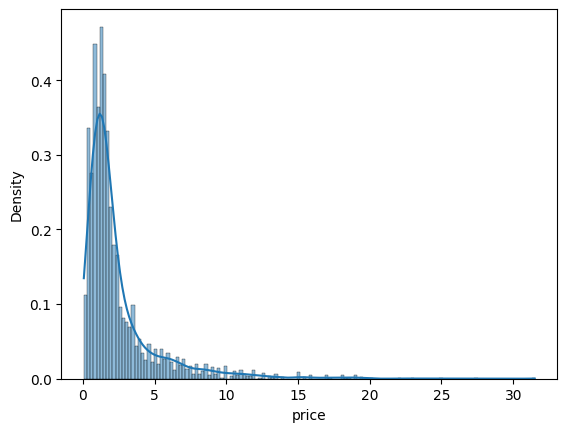

In [12]:
sns.histplot(df['price'], kde= True, stat= 'density')

In [13]:
y_log_transformed = np.log1p(df['price'])

pt = PowerTransformer(method= 'box-cox')

y_box_transformed = pt.fit_transform(y.values.reshape(-1, 1))

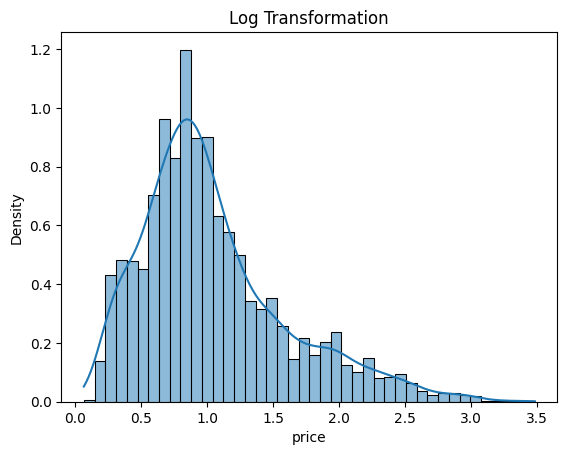

In [14]:
sns.histplot(y_log_transformed, kde= True, stat= 'density')
plt.title('Log Transformation')
plt.show()

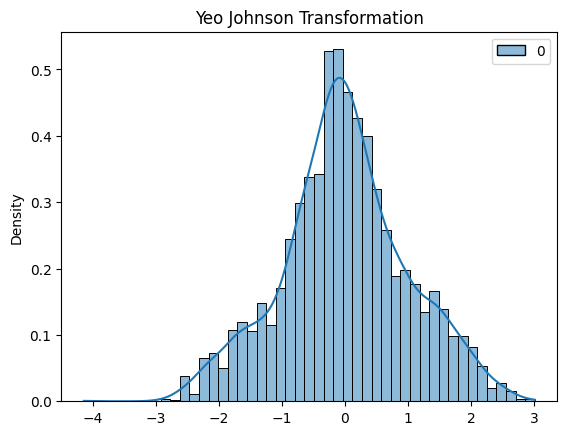

In [15]:
sns.histplot(y_box_transformed, kde= True, stat= 'density')
plt.title('Yeo Johnson Transformation')
plt.show()

**Ordinal Encoding**

In [16]:
# columns_to_encode = ['property_type','sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']
columns_to_encode = [0, 1, 4, 5, 9, 10, 11]

In [17]:
df.columns

Index(['property_type', 'sector', 'bedRoom', 'bathroom', 'balcony',
       'agePossession', 'built_up_area', 'servant room', 'store room',
       'furnishing_type', 'luxury_category', 'floor_category', 'price'],
      dtype='object')

**Log Transformation R2 and MAE**

In [18]:
preprocessor = ColumnTransformer(
    transformers= [
    # ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servent room', 'store room']),
    ('num', StandardScaler(), [2, 3, 6, 7, 8]),
    ('cat', OrdinalEncoder(), columns_to_encode),
], remainder= 'passthrough'
)

In [19]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [20]:
kfold = KFold(n_splits= 10, shuffle= True, random_state= 42)
scores = cross_val_score(pipeline, X, y, cv= kfold, scoring= 'r2').mean()

print('Log CV score: ', scores)

Log CV score:  0.6693860703972992


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y_log_transformed,test_size=0.2,random_state=42)

In [22]:
pipeline.fit(X_train,y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [23]:
y_pred = np.expm1(pipeline.predict(X_test))
mean_absolute_error(np.expm1(y_test), y_pred)

0.8883894836392308

**Box Cox Transformation R2 and MAE**

In [24]:
kfold = KFold(n_splits= 10, shuffle= True, random_state= 42)
scores = cross_val_score(pipeline, X, y_box_transformed, cv= kfold, scoring= 'r2').mean()

print('Yeo Johnson CV score: ', scores)

Yeo Johnson CV score:  0.6776690280616717


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y_box_transformed,test_size=0.2,random_state=42)

In [26]:
pipeline.fit(X_train,y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [27]:
y_pred = pt.inverse_transform(pipeline.predict(X_test).reshape(-1, 1))

mean_absolute_error(pt.inverse_transform(y_test).reshape(-1, 1), y_pred)

1.0666019871134513

In [28]:
def scorer(model_name, model):
    output = []
    output.append(model_name)
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    kfold = KFold(n_splits= 10, shuffle= True, random_state= 42)
    scores_log = cross_val_score(pipeline, X, y_log_transformed, cv= kfold, scoring= 'r2', n_jobs= -1)
    output.append(scores_log.mean())
    
    y_pred_log_transformed = cross_val_predict(pipeline, X, y_log_transformed, cv=kfold, n_jobs= -1)
    y_pred_log_original = np.expm1(y_pred_log_transformed)
    mae = mean_absolute_error(y, y_pred_log_original)  # Compare to original y
    output.append(mae)
    
    
    scores_box = cross_val_score(pipeline, X, y_box_transformed, cv= kfold, scoring= 'r2', n_jobs= -1)
    output.append(scores_box.mean())
    
    y_pred_box_transformed = cross_val_predict(pipeline, X, y_box_transformed, cv=kfold, n_jobs= -1)
    y_pred_box_original = pt.inverse_transform(y_pred_box_transformed.reshape(-1, 1)).flatten()
    mae = mean_absolute_error(y, y_pred_box_original)  # Compare to original y
    output.append(mae)
    
    return output

In [29]:
model_dict = {
    'linear_reg':LinearRegression(n_jobs= -1),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(n_jobs= -1),
    'extra trees': ExtraTreesRegressor(n_jobs= -1),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'xgboost':XGBRegressor()
}

In [30]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [31]:
model_output

[['linear_reg',
  np.float64(0.7343478143531247),
  0.9130268453067129,
  np.float64(0.6776690280616717),
  1.4174227273661733],
 ['svr',
  np.float64(0.7581674676960773),
  0.8521670001686823,
  np.float64(0.6908102513362057),
  0.9771367712457124],
 ['ridge',
  np.float64(0.7343516160088195),
  0.912971226959096,
  np.float64(0.6776717491724711),
  1.4167276697534534],
 ['LASSO',
  np.float64(0.005189090498454419),
  1.55494882577803,
  np.float64(-0.0017951527709994864),
  1.5226858573752173],
 ['decision tree',
  np.float64(0.7958093158986006),
  0.6611397528252524,
  np.float64(0.8117739535804616),
  0.6614402709808932],
 ['random forest',
  np.float64(0.8876062271787877),
  0.5087972132773115,
  np.float64(0.8889766547143392),
  0.5125190959438582],
 ['extra trees',
  np.float64(0.8711761936429283),
  0.556239237773155,
  np.float64(0.8776690039923144),
  0.5579083182683601],
 ['gradient boosting',
  np.float64(0.8782058068350149),
  0.5730535140320611,
  np.float64(0.87695350413

In [33]:
model_df = pd.DataFrame(model_output, columns=['name','r2_log','mae_log', 'r2_box', 'mae_box'])
model_df.sort_values(by= 'mae_box')

,name,r2_log,mae_log,r2_box,mae_box
9,xgboost,0.893158,0.503436,0.895275,0.505169
5,random forest,0.887606,0.508797,0.888977,0.512519
6,extra trees,0.871176,0.556239,0.877669,0.557908
7,gradient boosting,0.878206,0.573054,0.876954,0.579276
4,decision tree,0.795809,0.661140,0.811774,0.661440
8,adaboost,0.767372,0.831035,0.774331,0.873012
1,svr,0.758167,0.852167,0.690810,0.977137
2,ridge,0.734352,0.912971,0.677672,1.416728
0,linear_reg,0.734348,0.913027,0.677669,1.417423
3,LASSO,0.005189,1.554949,-0.001795,1.522686
